<a href="https://colab.research.google.com/github/younghoonNa/PythonDT2/blob/main/3%EC%9D%BC%EC%B0%A8_Building_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Energy Prediction

## 데이터분석과 시각화, 머신러닝 알고리즘으로 빌딩의 전력 소모량 예측하기

Q : 여름에 고층 빌딩을 식히는 데 비용이 얼마나 드나요?<br/>
A : 많이 듭니다! 그리고 돈 뿐만 아니라 환경 영향도 있습니다.

건물 효율성을 개선하여 비용과 배출량을 줄이기 위해 상당한 투자가 이루어지고 있습니다. 문제는 개선이 효과적이었을까요? 

건물 소유주는 전력을 사용한 만큼 청구서를 발행하는데,전력 계량기가 특정 건물 유형에서는 작동하지 않아 전력 사용량 측정에도 어려움을 겪고 있습니다.재의 추정 방법은 단편화되어 있으며 확장 성이 좋지 않습니다. 일부는 특정 미터 유형을 가정하거나 다른 건물 유형에서 작동하지 않습니다.

이 데이터를 이용하여 냉수, 전기, 온수 및 증기 계량기 분야에서 건물 에너지 사용량의 정확한 모델을 개발하게 됩니다.

## 파일 구성
 - **train.csv**: 학습 데이터
 - **test.csv**: 평가 데이터
 - **submission.csv**: 제출 데이터

## 특성 설명
- `meter`-측정기 ID 코드입니다. {0 : 전기, 1 : 냉수, 2 : 증기, 3  : 온수}로 읽습니다. 모든 건물에 모든 미터 유형이있는 것은 아닙니다.
- `timestamp`-측정이 수행 된시기
- `meter_reading`-대상 변수 (Target, Label)입니다. kWh (또는 이에 상응하는) 단위의 에너지 소비. 이것은 측정 오류가있는 실제 데이터이며 모델링 오류의 기준 수준을 부과 할 것으로 예상됩니다.
- `site_id`- weather.csv 파일의 외래 키(foreign key)입니다.
- `building_id`-training.csv의 외래 키(foreign key)입니다.
- `primary_use`-EnergyStar 속성 유형 정의를 기반으로하는 건물의 기본 활동 범주 표시기
   - ['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Retail', 'Services',
       'Technology/science', 'Utility', 'Warehouse/storage']
- `square_feet`-건물의 전체 바닥 면적
- `year_built`-개관 연도
- `floor_count`-건물의 층 수
- `air_temperature.csv`- 섭씨 온도
- `cloud_coverage`-옥 타스에서 구름으로 덮인 하늘 부분
- `dew_ temperature`-섭씨 온도
- `precip_depth_1_hr`-밀리미터
- `sea_level_pressure`-밀리바 / 헥토 파스칼
- `wind_direction`-나침반 방향 (0-360)
- `wind_speed`-초당 미터

## 평가 측도
 - **`rmsle`**: 낮을수록 좋음

# 필수 모듈

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install jaen

In [3]:
# !pip install datawig

In [4]:
!pip install pycaret[full]

In [5]:
# ID@jaen.com
# ID를 문자열로 입력해주세요.
# ID = 20185124
email = '20185124@jaen.com'

In [6]:
from JAEN.project import Project
pjt = Project('빌딩 전력 소모량 예측', 
              '한림대-파이썬을활용한-머신러닝프로젝트',        
              '1차수 A반',       
              email)

# 데이터 다운로드

In [7]:
!wget -N --http-user=mysuni --http-passwd=mysuni1! http://sk.jaen.kr:8080/hl_energy_predictor.zip

--2022-02-16 07:59:43--  http://sk.jaen.kr:8080/hl_energy_predictor.zip
Resolving sk.jaen.kr (sk.jaen.kr)... 49.247.134.238
Connecting to sk.jaen.kr (sk.jaen.kr)|49.247.134.238|:8080... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Authentication required."
Reusing existing connection to sk.jaen.kr:8080.
HTTP request sent, awaiting response... 304 Not Modified
File ‘hl_energy_predictor.zip’ not modified on server. Omitting download.



In [8]:
import zipfile

# 데이터 폴더
DATA_DIR = './data'

with zipfile.ZipFile("hl_energy_predictor.zip" , "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

# Baseline

In [ ]:
# 데이터 로드
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

In [ ]:
train.head()

In [11]:
test.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,575,0,2016-01-01 12:00:00,4,5,33167,1963.0,4.0,5.0,0.0,-9.4,0.0,1020.6,0.0,0.0
1,585,0,2016-01-01 12:00:00,4,4,132394,1949.0,7.0,5.0,0.0,-9.4,0.0,1020.6,0.0,0.0
2,609,0,2016-01-01 12:00:00,4,0,141461,1907.0,6.0,5.0,0.0,-9.4,0.0,1020.6,0.0,0.0
3,652,0,2016-01-01 12:00:00,4,0,150887,1959.0,9.0,5.0,0.0,-9.4,0.0,1020.6,0.0,0.0
4,597,0,2016-01-01 18:00:00,4,4,189425,1994.0,4.0,7.2,2.0,-7.2,0.0,1022.5,120.0,2.6


In [12]:
submission.head()

,building_id,meter_reading
0,575,0
1,585,0
2,609,0
3,652,0
4,597,0


# 데이터 특성 변경


In [13]:
# ['Education',
#  'Entertainment/public assembly',
#  'Food sales and service',
#  'Healthcare',
#  'Lodging/residential',
#  'Manufacturing/industrial', 
#  'Office',
#  'Other',
#  'Parking', 
#  'Public services', 
#  'Religious worship',
#  'Retail',
#  'Services',
#  'Technology/science',
#  'Utility',
#  'Warehouse/storage']

In [14]:
train.loc[train['primary_use'] == 14 , 'primary_use'] = 'Utility'
train.loc[train['primary_use'] == 13 , 'primary_use'] = 'Technology/science'
train.loc[train['primary_use'] == 9 , 'primary_use'] = 'Public services'
train.loc[train['primary_use'] == 8 , 'primary_use'] = 'Parking'
train.loc[train['primary_use'] == 4 , 'primary_use'] = 'Lodging/residential'
train.loc[train['primary_use'] == 1 , 'primary_use'] = 'Entertainment/public assembly'
train.loc[train['primary_use'] == 0 , 'primary_use'] = 'Education'

In [15]:
test.loc[test['primary_use'] == 14 , 'primary_use'] = 'Utility'
test.loc[test['primary_use'] == 13 , 'primary_use'] = 'Technology/science'
test.loc[test['primary_use'] == 9 , 'primary_use'] = 'Public services'
test.loc[test['primary_use'] == 8 , 'primary_use'] = 'Parking'
test.loc[test['primary_use'] == 4 , 'primary_use'] = 'Lodging/residential'
test.loc[test['primary_use'] == 1 , 'primary_use'] = 'Entertainment/public assembly'
test.loc[test['primary_use'] == 0 , 'primary_use'] = 'Education'

In [ ]:
train.info()

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9666 entries, 0 to 9665
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   building_id         9666 non-null   int64  
 1   meter               9666 non-null   int64  
 2   timestamp           9666 non-null   object 
 3   site_id             9666 non-null   int64  
 4   primary_use         9666 non-null   object 
 5   square_feet         9666 non-null   int64  
 6   year_built          9666 non-null   float64
 7   floor_count         9666 non-null   float64
 8   air_temperature     9666 non-null   float64
 9   cloud_coverage      9666 non-null   float64
 10  dew_temperature     9666 non-null   float64
 11  precip_depth_1_hr   9666 non-null   float64
 12  sea_level_pressure  9666 non-null   float64
 13  wind_direction      9666 non-null   float64
 14  wind_speed          9666 non-null   float64
dtypes: float64(9), int64(4), object(2)
memory usage: 1.1+ M

# 시계열 데이터로 바꾸기/

In [18]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = train.drop(['meter', 'building_id', 'site_id'], axis = 1)

In [19]:
train['hour'] = train['timestamp'].dt.hour
train['month'] = train['timestamp'].dt.month
train['dayofweek'] = train['timestamp'].dt.dayofweek

train = train.astype({'hour':int, 'month':int, 'dayofweek':int})

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514 entries, 0 to 22513
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           22514 non-null  datetime64[ns]
 1   meter_reading       22514 non-null  float64       
 2   primary_use         22514 non-null  object        
 3   square_feet         22514 non-null  int64         
 4   year_built          22514 non-null  float64       
 5   floor_count         22514 non-null  float64       
 6   air_temperature     22514 non-null  float64       
 7   cloud_coverage      22514 non-null  float64       
 8   dew_temperature     22514 non-null  float64       
 9   precip_depth_1_hr   22514 non-null  float64       
 10  sea_level_pressure  22514 non-null  float64       
 11  wind_direction      22514 non-null  float64       
 12  wind_speed          22514 non-null  float64       
 13  hour                22514 non-null  int64     

In [21]:
test['timestamp'] = pd.to_datetime(test['timestamp'])
test = test.drop(['meter', 'building_id', 'site_id'], axis = 1)

In [22]:
test['hour'] = test['timestamp'].dt.hour
test['month'] = test['timestamp'].dt.month
test['dayofweek'] = test['timestamp'].dt.dayofweek

test = test.astype({'hour':int, 'month':int, 'dayofweek':int})

In [23]:
train.columns

Index(['timestamp', 'meter_reading', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'hour', 'month', 'dayofweek'],
      dtype='object')

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514 entries, 0 to 22513
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           22514 non-null  datetime64[ns]
 1   meter_reading       22514 non-null  float64       
 2   primary_use         22514 non-null  object        
 3   square_feet         22514 non-null  int64         
 4   year_built          22514 non-null  float64       
 5   floor_count         22514 non-null  float64       
 6   air_temperature     22514 non-null  float64       
 7   cloud_coverage      22514 non-null  float64       
 8   dew_temperature     22514 non-null  float64       
 9   precip_depth_1_hr   22514 non-null  float64       
 10  sea_level_pressure  22514 non-null  float64       
 11  wind_direction      22514 non-null  float64       
 12  wind_speed          22514 non-null  float64       
 13  hour                22514 non-null  int64     

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9666 entries, 0 to 9665
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           9666 non-null   datetime64[ns]
 1   primary_use         9666 non-null   object        
 2   square_feet         9666 non-null   int64         
 3   year_built          9666 non-null   float64       
 4   floor_count         9666 non-null   float64       
 5   air_temperature     9666 non-null   float64       
 6   cloud_coverage      9666 non-null   float64       
 7   dew_temperature     9666 non-null   float64       
 8   precip_depth_1_hr   9666 non-null   float64       
 9   sea_level_pressure  9666 non-null   float64       
 10  wind_direction      9666 non-null   float64       
 11  wind_speed          9666 non-null   float64       
 12  hour                9666 non-null   int64         
 13  month               9666 non-null   int64       

# 그래프

In [27]:
test['primary_use'].value_counts()

Education                        7252
Entertainment/public assembly     781
Lodging/residential               618
2                                 413
3                                 263
5                                 228
6                                 111
Name: primary_use, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='meter_reading'>

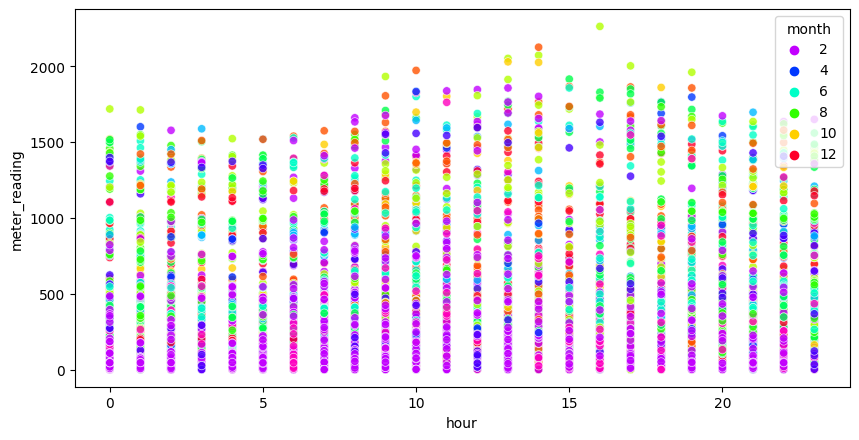

In [28]:
plt.figure(figsize=(10,5), dpi=100)
sns.scatterplot(data=train, x='hour',y='meter_reading', hue = 'month',palette='gist_rainbow_r', alpha=0.8)

In [29]:
train.loc[train['primary_use'] == 'Utility', 'square_feet'].value_counts()

23432    266
Name: square_feet, dtype: int64

<AxesSubplot:xlabel='primary_use', ylabel='meter_reading'>

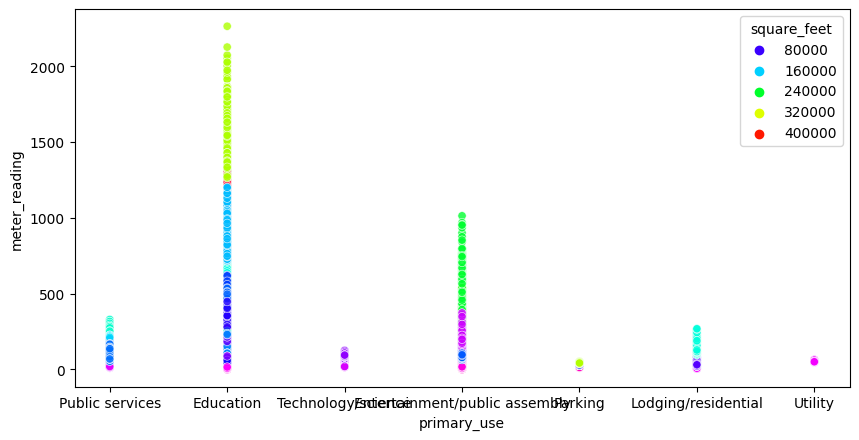

In [30]:
plt.figure(figsize=(10,5), dpi=100)
sns.scatterplot(data=train, x='primary_use',y='meter_reading',  hue = 'square_feet', palette='gist_rainbow_r', alpha=0.8)

In [31]:
train.loc[train['square_feet'] == 71994, 'primary_use'].value_counts()

Lodging/residential    276
Name: primary_use, dtype: int64

In [32]:
train.loc[train['square_feet'] == 86959, 'primary_use'].value_counts()

Lodging/residential    114
Name: primary_use, dtype: int64

In [33]:
train.loc[train['square_feet'] == 185200, 'primary_use'].value_counts()

Lodging/residential    276
Name: primary_use, dtype: int64

In [34]:
train.loc[train['square_feet'] == 23012, 'primary_use'].value_counts()

Lodging/residential    256
Name: primary_use, dtype: int64

In [35]:
test.loc[test['primary_use'] == 2, 'square_feet'].value_counts()

71994     135
185200    130
23012     114
86959      34
Name: square_feet, dtype: int64

In [36]:
test.loc[test['primary_use'] == 2, 'primary_use'] = 'Lodging/residential'

In [37]:
train.loc[train['square_feet'] == 306140, 'primary_use'].value_counts()

Parking    274
Name: primary_use, dtype: int64

In [38]:
train.loc[train['square_feet'] == 98539, 'primary_use'].value_counts()

Parking    243
Name: primary_use, dtype: int64

In [39]:
train.loc[train['square_feet'] == 387, 'primary_use'].value_counts()

Parking    103
Name: primary_use, dtype: int64

In [40]:
test.loc[test['primary_use'] == 3, 'primary_use'] = "Parking"

In [41]:
test.loc[test['primary_use'] == 5, 'square_feet'].value_counts()

33167    126
53234    102
Name: square_feet, dtype: int64

In [42]:
train.loc[train['square_feet'] == 33167, 'primary_use'].value_counts()

Technology/science    279
Name: primary_use, dtype: int64

In [43]:
train.loc[train['square_feet'] == 53234, 'primary_use'].value_counts()

Technology/science    247
Name: primary_use, dtype: int64

In [44]:
test.loc[test['primary_use'] == 5, 'primary_use'] = "Technology/science"

In [45]:
test.loc[test['primary_use'] == 6, 'square_feet'].value_counts()

23432    111
Name: square_feet, dtype: int64

In [46]:
test.loc[test['primary_use'] == 6, 'primary_use'] = "Utility"

In [48]:
# 범주형 데이터 바꾸고
pr_es = pd.get_dummies(train['primary_use'])

pr_es_TEST = pd.get_dummies(test['primary_use'])

train = pd.concat((train, pr_es), axis=1)
test = pd.concat((test,pr_es_TEST), axis=1)

In [49]:
train = train.drop('primary_use', axis=1)
test = test.drop('primary_use', axis=1)

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9666 entries, 0 to 9665
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   timestamp                      9666 non-null   datetime64[ns]
 1   square_feet                    9666 non-null   int64         
 2   year_built                     9666 non-null   float64       
 3   floor_count                    9666 non-null   float64       
 4   air_temperature                9666 non-null   float64       
 5   cloud_coverage                 9666 non-null   float64       
 6   dew_temperature                9666 non-null   float64       
 7   precip_depth_1_hr              9666 non-null   float64       
 8   sea_level_pressure             9666 non-null   float64       
 9   wind_direction                 9666 non-null   float64       
 10  wind_speed                     9666 non-null   float64       
 11  hour             

In [51]:
# plt.figure(figsize=(10,5), dpi=100)
# sns.scatterplot(data=train , x='meter_reading', y='hour',hue='primary_use',palette='gist_rainbow_r', alpha=0.8)
# plt.ylim(-1,20)

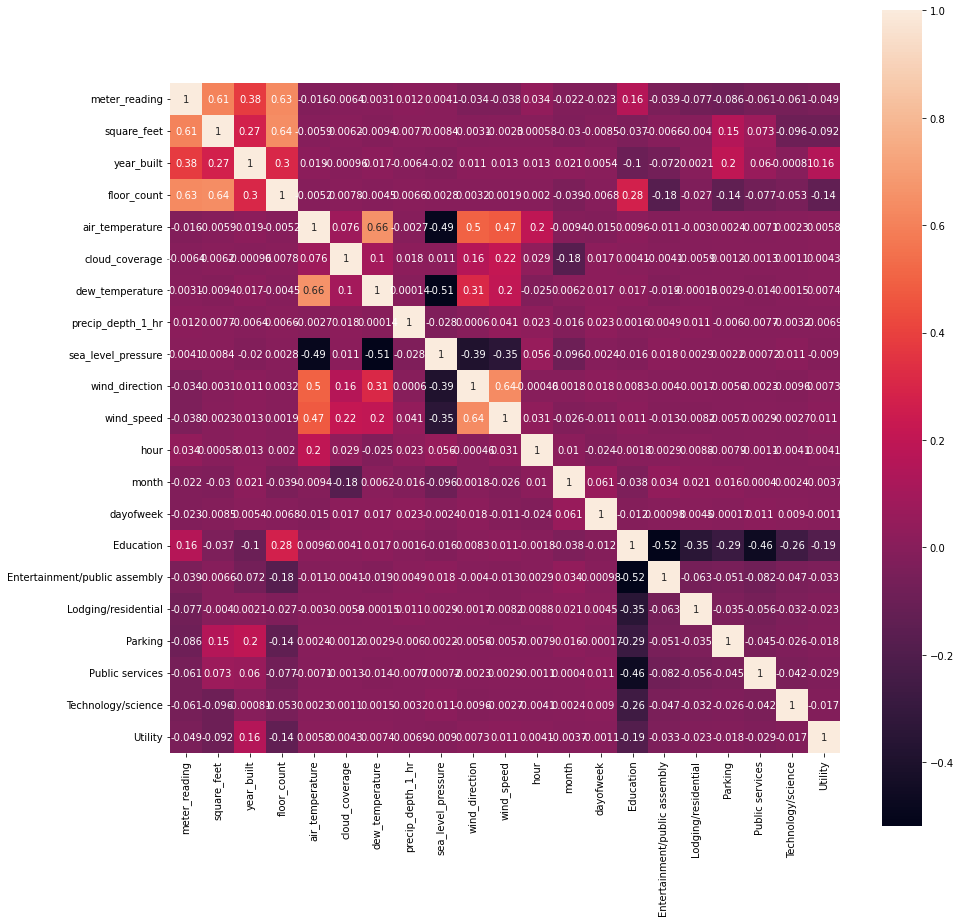

In [52]:
plt.subplots(figsize=(15,15))
sns.heatmap(train.corr(), mask=np.zeros_like(train.corr(), dtype=bool),
            square=True, annot=True)
plt.show()

meter_reading                       AxesSubplot(0.125,0.787927;0.133621x0.0920732)
square_feet                      AxesSubplot(0.285345,0.787927;0.133621x0.0920732)
year_built                        AxesSubplot(0.44569,0.787927;0.133621x0.0920732)
floor_count                      AxesSubplot(0.606034,0.787927;0.133621x0.0920732)
air_temperature                  AxesSubplot(0.766379,0.787927;0.133621x0.0920732)
cloud_coverage                      AxesSubplot(0.125,0.677439;0.133621x0.0920732)
dew_temperature                  AxesSubplot(0.285345,0.677439;0.133621x0.0920732)
precip_depth_1_hr                 AxesSubplot(0.44569,0.677439;0.133621x0.0920732)
sea_level_pressure               AxesSubplot(0.606034,0.677439;0.133621x0.0920732)
wind_direction                   AxesSubplot(0.766379,0.677439;0.133621x0.0920732)
wind_speed                          AxesSubplot(0.125,0.566951;0.133621x0.0920732)
hour                             AxesSubplot(0.285345,0.566951;0.133621x0.0920732)
mont

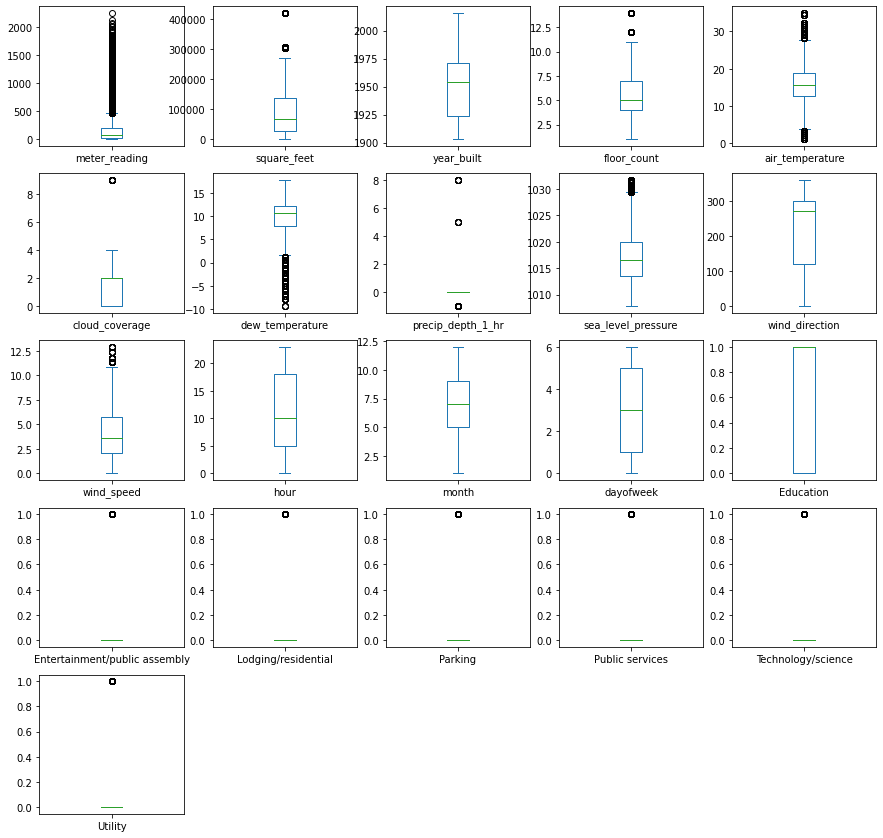

In [53]:
train.plot(kind='box', subplots=True, layout=(7, 5), figsize=(15, 21))

In [54]:
train.columns

Index(['timestamp', 'meter_reading', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'month', 'dayofweek', 'Education',
       'Entertainment/public assembly', 'Lodging/residential', 'Parking',
       'Public services', 'Technology/science', 'Utility'],
      dtype='object')

In [63]:
features = [
            # 'timestamp', 
            # 'meter_reading', 
            'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'hour',
        # 'year',
        #  'dayofweek'
]

f = [
    #  'timestamp',
    #  'meter_reading',
     'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour',
      # 'season', 
     'dayofweek',
     'Education',
       'Entertainment/public assembly', 'Lodging/residential', 
     'Parking',
      #  'Public services',
      'Technology/science',
      'Utility'
]

f2 = [
    #  'timestamp',
     'meter_reading',
     'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour',
      # 'season', 
     'dayofweek',
     'Education',
       'Entertainment/public assembly', 'Lodging/residential', 
     'Parking',
      #  'Public services',
      'Technology/science',
      'Utility'
]

set_up_features = [
            # 'timestamp', 
            'meter_reading', 
            'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'hour',
        # 'year',
         'dayofweek'
]

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514 entries, 0 to 22513
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   timestamp                      22514 non-null  datetime64[ns]
 1   meter_reading                  22514 non-null  float64       
 2   square_feet                    22514 non-null  int64         
 3   year_built                     22514 non-null  float64       
 4   floor_count                    22514 non-null  float64       
 5   air_temperature                22514 non-null  float64       
 6   cloud_coverage                 22514 non-null  float64       
 7   dew_temperature                22514 non-null  float64       
 8   precip_depth_1_hr              22514 non-null  float64       
 9   sea_level_pressure             22514 non-null  float64       
 10  wind_direction                 22514 non-null  float64       
 11  wind_speed     

In [57]:
X = train[f]
Y = train.meter_reading 

In [58]:
# 데이터 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train ,y_test = train_test_split(X, Y, random_state=0)

# 파이캐럿


In [64]:
from pycaret.regression import *

setup_ = setup(data = train, target = 'meter_reading', n_jobs = -1, train_size = 0.9, feature_interaction = True, feature_ratio = True, silent = True)

,Description,Value
0,session_id,4730
1,Target,meter_reading
2,Original Data,"(22514, 19)"
3,Missing Values,False
4,Numeric Features,17
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(20262, 34)"


In [73]:
rf1 = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13.7949,889.9777,29.8325,0.9900,0.1904,0.1494
1,13.6005,815.5183,28.5573,0.9910,0.2356,0.6128
2,15.1080,1184.7569,34.4203,0.9866,0.2210,0.5502
3,13.5626,874.9168,29.5790,0.9877,0.2112,0.1689
4,14.3789,1051.6226,32.4287,0.9875,0.1977,0.1564
5,15.2256,1289.2421,35.9060,0.9853,0.2145,0.3549
6,14.4033,916.7520,30.2779,0.9884,0.1949,0.1513
7,14.0720,875.1883,29.5836,0.9890,0.2288,0.4817
8,13.6896,880.7305,29.6771,0.9898,0.2038,0.1598
9,14.3662,946.8456,30.7709,0.9892,0.2070,0.1643


In [ ]:
rf1_tune = tune_model(rf1)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:18:23
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 68.0min


In [ ]:
final_model = finalize_model(rf1_tune)
pred= predict_model(final_model, test)
pred

In [68]:
best3 = compare_models(n_select = 3, sort = 'RMSLE', fold = 10, cross_validation=True)
best3

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,14.2202,9.725551e+02,31.1033,0.9885,0.2105,0.2950,12.719
et,Extra Trees Regressor,14.5532,1.013707e+03,31.7880,0.9880,0.2123,0.3026,8.906
dt,Decision Tree Regressor,18.4152,1.812954e+03,42.4637,0.9785,0.2886,0.3270,0.209
knn,K Neighbors Regressor,22.8630,1.990833e+03,44.5392,0.9764,0.3123,0.3886,0.195
lightgbm,Light Gradient Boosting Machine,16.2491,9.514811e+02,30.7808,0.9887,0.3658,0.8252,1.080
catboost,CatBoost Regressor,15.7918,9.127867e+02,30.1561,0.9892,0.3932,0.9486,9.974
gbr,Gradient Boosting Regressor,27.6803,2.003073e+03,44.7236,0.9762,0.6539,2.0756,3.450
huber,Huber Regressor,112.6521,4.517954e+04,212.4510,0.4634,0.9219,2.0510,0.276
omp,Orthogonal Matching Pursuit,123.8083,4.028557e+04,200.6309,0.5216,1.3915,12.0360,0.052
lasso,Lasso Regression,116.4170,3.627473e+04,190.3817,0.5695,1.3960,15.2785,0.668


[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=4730, verbose=0, warm_start=False),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=4730, verbose=0, warm_start=False),
 Decisi

In [66]:
# 랜덤포레스트로 학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from lightgbm import LGBMRegressor




model = RandomForestRegressor()
model.fit(x_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
pred = model.predict(x_test)
pred = pd.DataFrame(pred) 
pred.loc[pred[0] < 0 , 0] = 0 
pred

In [ ]:
# rmsle
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y_test, pred)

In [ ]:
# 제출 데이터 설정
submission['meter_reading'] = model.predict(test[f])
submission

# 이제부터 자유롭게 분석, 예측을 진행하시면 됩니다.

In [ ]:
# 제출
pjt.submit(submission)